In [2]:
import datasets

import numpy as np
import torch
import torchaudio
import torchaudio.transforms as T
import pickle
import librosa
import torch
import torchgmm.bayes as bayes
import os
from utils import group_samples_by_speaker, create_balanced_duration_dataset_from_groups,compute_mfcc, save_dataset_with_mfcc, load_dataset_with_mfcc, create_balanced_dataset

import natsort
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform


### download dataset

In [ ]:
"""
import aiohttp
dataset = datasets.load_dataset("librispeech_asr", 
                                "clean", 
                                split="train.100",
    storage_options={'client_kwargs': {'timeout': aiohttp.ClientTimeout(total=3600)}}
)
dataset.save_to_disk("./data/librispeech_hf")"""

### load and create subsets

In [ ]:
dataset = datasets.load_from_disk("./data/librispeech_hf")

In [ ]:
speaker_groups = group_samples_by_speaker(dataset)

In [ ]:
# Create balanced datasets of different durations:

seeds=[12, 34, 43, 734, 75]
duration = [300, 600, 1800, 3600]
nb_clusters = [8,16,128,256]
for seed in seeds:
    for time in duration:
        random.seed(seed)
        dataset_balanced = create_balanced_duration_dataset_from_groups(speaker_groups, target_duration=time)
        save_dataset_with_mfcc(dataset_balanced, f"./data/librispeech_balanced_{time}_seed_{seed}")
        mfcc_dataset = load_dataset_with_mfcc(f"./data/librispeech_balanced_{time}_seed_{seed}")
        all_mfcc_frames = []

        for sample in mfcc_dataset:
            # Convert the mfcc list to a numpy array (shape: n_frames x n_mfcc)
            mfcc_frames = np.array(sample["mfcc"])
            all_mfcc_frames.append(mfcc_frames)

        # Concatenate all frames along the time axis.
        # This yields an array of shape (total_n_frames, n_mfcc)
        all_mfcc = np.vstack(all_mfcc_frames)
        print("Total MFCC frames:", all_mfcc.shape[0])
        print("MFCC feature dimension:", all_mfcc.shape[1])

        # Convert the NumPy array to a PyTorch tensor.
        mfcc_tensor = torch.tensor(all_mfcc, dtype=torch.float32)
        torch.save(mfcc_tensor, f'./data/mfcc_tensors/tensor_{time}_seed_{seed}.pt')

        nb_clusters = 16  
        gmm = bayes.GaussianMixture(
            num_components=nb_clusters,
            batch_size=1024,  # Process the data in batches of 1024 samples
            trainer_params={
                "max_epochs": 40,       
                "accelerator": "cpu",   # Force CPU training (MPS on macbook is not supported)
            }
        )
        gmm = gmm.fit(mfcc_tensor)

        save_path = f"./data/trained_models/trained_gmm_{time}_seed_{seed}"
        gmm.save(save_path)
        print(f"GMM model saved to {save_path}")
    

save subset

In [ ]:
save_dataset_with_mfcc(hdataset, "./data/mfcc_datasets/mn5_mfcc")

In [ ]:
mfcc_dataset = load_dataset_with_mfcc("./data/mfcc_datasets/mn5_mfcc")

In [ ]:


# --- Step 1: Flatten MFCC frames from the dataset ---
# Each sample in mfcc_dataset has a key "mfcc" (a list of lists where each inner list is one MFCC frame)
all_mfcc_frames = []

for sample in mfcc_dataset:
    # Convert the mfcc list to a numpy array (shape: n_frames x n_mfcc)
    mfcc_frames = np.array(sample["mfcc"])
    all_mfcc_frames.append(mfcc_frames)

# Concatenate all frames along the time axis.
# This yields an array of shape (total_n_frames, n_mfcc)
all_mfcc = np.vstack(all_mfcc_frames)
print("Total MFCC frames:", all_mfcc.shape[0])
print("MFCC feature dimension:", all_mfcc.shape[1])

# Convert the NumPy array to a PyTorch tensor.
mfcc_tensor = torch.tensor(all_mfcc, dtype=torch.float32)


In [ ]:
torch.save(mfcc_tensor, './data/mfcc_tensors/mn5_mfcc_tensor.pt')

### train 

In [ ]:
#load mfcc tensor
mfcc_tensor = torch.load('./data/mfcc_tensors/halfhour_mfcc_tensor.pt')
print("Total MFCC frames:", mfcc_tensor.shape[0])

In [ ]:
# Create the GMM model with batch training parameters.


nb_clusters = 16  
gmm = bayes.GaussianMixture(
    num_components=nb_clusters,
    batch_size=1024,  # Process the data in batches of 1024 samples
    trainer_params={
        "max_epochs": 40,       
        "accelerator": "cpu",   # Force CPU training (MPS on macbook is not supported)
    }
)

In [ ]:
#fit model
gmm = gmm.fit(mfcc_tensor)

In [ ]:
#save model

save_path = "./data/trained_models/halfhour_trained_gmm"
gmm.save(save_path)
print(f"GMM model saved to {save_path}")


In [ ]:

save_path = "./data/trained_models/halfhour_trained_gmm"

# 8. Later, you can load the model back using:
gmm = bayes.GaussianMixture.load(save_path)

# 3. Compute the average negative log-likelihood (NLL) for the data.
avg_nll = gmm.score(mfcc_tensor)
print(f"Average negative log-likelihood: {avg_nll:.2f}")



# 6. Inspect some of the fitted attributes:
#    (Note: The names of attributes may depend on your version of torchgmm.)

print("Convergence status:", gmm.converged_)
print("Number of EM iterations:", gmm.num_iter_)
print("Last recorded average NLL:", gmm.nll_)

In [ ]:
#qques test inutiles 
# 1. Predict the most likely component for each datapoint.
predicted_labels = gmm.predict(mfcc_tensor)
print("Predicted cluster assignments (first 10 datapoints):")
print(predicted_labels[:10])

# 2. Get the probability distribution (responsibilities) over components.
responsibilities = gmm.predict_proba(mfcc_tensor)
print("Responsibilities for the first 5 datapoints:")
print(responsibilities[:5])




In [4]:



def process_stimulus(audio_file_path, sample_rate=16000):
    # Load the audio using librosa (or another method)
    audio_array, sr = librosa.load(audio_file_path, sr=sample_rate)
    mfcc_features = compute_mfcc(audio_array, sr)
    return mfcc_features  # NumPy array of shape (n_frames, n_mfcc)

# List your stimulus file paths (16 audio files)

# List your stimulus file paths (16 audio files)
stimulus_files = natsort.natsorted(os.listdir(r'./data/stimuli'))
stimulus_files = [os.path.join(r'./data/stimuli', file) for file in stimulus_files]

print(stimulus_files)
"""stimulus_files = os.listdir("./data/stimuli")
stimulus_files = [os.path.join("./data/stimuli", file) for file in stimulus_files]"""

print(stimulus_files)  




# Process each stimulus
stimulus_mfccs = []
for file_path in stimulus_files:
    print(f"Processing stimulus: {file_path}")
    mfcc = process_stimulus(file_path)
    stimulus_mfccs.append(mfcc)

# --- Step 2: Get cluster responsibilities for each stimulus ---
# Suppose gmm is your trained GaussianMixture model.
# We will compute the average responsibilities per stimulus.

stimulus_cluster_posteriors = []  # list of shape (num_components,) per stimulus
stimulus_labels = ["r", #S
                   "r", #S
                   "l", #S
                   "l", #S
                   "r", #S
                   "r", #S
                   "l", #S
                   "l", #S
                   "r", #S
                   "r", #S
                   "l", #S
                   "l", #S
                   "r", #S
                   "r", #S
                   "l", #S
                    "l"] #S


for mfcc in stimulus_mfccs:
    # Convert to torch tensor (float32)
    mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32)
    # Get responsibilities (posterior probabilities) for each frame.
    responsibilities = gmm.predict_proba(mfcc_tensor)
    # Average the responsibilities over all frames.
    print("resp",responsibilities.shape)
    avg_resp = responsibilities.mean(dim=0)
    print("avg",avg_resp.shape)
    stimulus_cluster_posteriors.append(avg_resp.detach().cpu().numpy())

# Now, stimulus_cluster_posteriors is a list of 16 vectors (each of length num_components).



['./data/stimuli/1_yt8016.wav', './data/stimuli/2_yt8020.wav', './data/stimuli/3_yt8024.wav', './data/stimuli/4_yt8028.wav', './data/stimuli/5_yt10016.wav', './data/stimuli/6_yt10020.wav', './data/stimuli/7_yt10024.wav', './data/stimuli/8_yt10028.wav', './data/stimuli/9_yt12016.wav', './data/stimuli/10_yt12020.wav', './data/stimuli/11_yt12024.wav', './data/stimuli/12_yt12028.wav', './data/stimuli/13_yt14016.wav', './data/stimuli/14_yt14020.wav', './data/stimuli/15_yt14024.wav', './data/stimuli/16_yt14028.wav']
['./data/stimuli/1_yt8016.wav', './data/stimuli/2_yt8020.wav', './data/stimuli/3_yt8024.wav', './data/stimuli/4_yt8028.wav', './data/stimuli/5_yt10016.wav', './data/stimuli/6_yt10020.wav', './data/stimuli/7_yt10024.wav', './data/stimuli/8_yt10028.wav', './data/stimuli/9_yt12016.wav', './data/stimuli/10_yt12020.wav', './data/stimuli/11_yt12024.wav', './data/stimuli/12_yt12028.wav', './data/stimuli/13_yt14016.wav', './data/stimuli/14_yt14020.wav', './data/stimuli/15_yt14024.wav', '

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/julienf/.pyenv/versions/3.11.11/envs/ml/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Processing stimulus: ./data/stimuli/2_yt8020.wav
Processing stimulus: ./data/stimuli/3_yt8024.wav
Processing stimulus: ./data/stimuli/4_yt8028.wav
Processing stimulus: ./data/stimuli/5_yt10016.wav
Processing stimulus: ./data/stimuli/6_yt10020.wav
Processing stimulus: ./data/stimuli/7_yt10024.wav
Processing stimulus: ./data/stimuli/8_yt10028.wav
Processing stimulus: ./data/stimuli/9_yt12016.wav
Processing stimulus: ./data/stimuli/10_yt12020.wav
Processing stimulus: ./data/stimuli/11_yt12024.wav
Processing stimulus: ./data/stimuli/12_yt12028.wav
Processing stimulus: ./data/stimuli/13_yt14016.wav
Processing stimulus: ./data/stimuli/14_yt14020.wav
Processing stimulus: ./data/stimuli/15_yt14024.wav
Processing stimulus: ./data/stimuli/16_yt14028.wav
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.05it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



resp torch.Size([59, 16])
avg torch.Size([16])
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 465.98it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



resp torch.Size([59, 16])
avg torch.Size([16])
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 512.00it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



resp torch.Size([59, 16])
avg torch.Size([16])
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 538.49it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



resp torch.Size([59, 16])
avg torch.Size([16])
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 709.22it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



resp torch.Size([59, 16])
avg torch.Size([16])
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 505.03it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



resp torch.Size([59, 16])
avg torch.Size([16])
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 704.69it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



resp torch.Size([59, 16])
avg torch.Size([16])
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 552.10it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



resp torch.Size([59, 16])
avg torch.Size([16])
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.20it/s] 

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



resp torch.Size([59, 16])
avg torch.Size([16])
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 623.13it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



resp torch.Size([59, 16])
avg torch.Size([16])
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 458.24it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



resp torch.Size([59, 16])
avg torch.Size([16])
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 816.33it/s] 

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



resp torch.Size([59, 16])
avg torch.Size([16])
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 557.46it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



resp torch.Size([59, 16])
avg torch.Size([16])
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 506.31it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



resp torch.Size([59, 16])
avg torch.Size([16])
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 588.34it/s]
resp torch.Size([59, 16])
avg torch.Size([16])


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 569.80it/s]
resp torch.Size([59, 16])
avg torch.Size([16])


In [ ]:
# Example inputs:
# stimulus_cluster_posteriors: list of 16 numpy arrays, each of shape (num_clusters,)
# For instance, if you have 32 clusters then each array is of shape (32,).
# These come from averaging the responsibilities (posterior probabilities) over the MFCC frames of each stimulus.


# stimulus_labels: a list of 16 labels corresponding to your 16 stimuli.
# Here we assume that the stimuli are labeled "r" for /r/ sounds and "l" for /l/ sounds.


# Convert the list of posterior vectors into a 2D array for easier manipulation.
posteriors = np.stack(stimulus_cluster_posteriors, axis=0)  # shape: (num_stimuli, num_clusters)
num_stimuli, num_clusters = posteriors.shape

# Separate indices for /r/ and /l/ stimuli.
r_indices = [i for i, lab in enumerate(stimulus_labels) if lab.lower() == "r"]
l_indices = [i for i, lab in enumerate(stimulus_labels) if lab.lower() == "l"]

# Compute average posterior probability for each cluster for each group.
avg_r = posteriors[r_indices, :].mean(axis=0)
avg_l = posteriors[l_indices, :].mean(axis=0)

# Plot the average probabilities for each cluster side by side.
x = np.arange(num_clusters)
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width/2, avg_r, width, label="/r/ stimuli")
ax.bar(x + width/2, avg_l, width, label="/l/ stimuli")
ax.set_xlabel("Cluster Index")
ax.set_ylabel("Average Posterior Probability")
ax.set_title("Average GMM Cluster Probabilities for /r/ vs. /l/ Stimuli")
ax.set_xticks(x)
ax.legend()
plt.show()


In [ ]:
responsibilities = gmm.predict_proba(mfcc_tensor)  # shape: [N, K]
effective_counts = responsibilities.sum(axis=0)
print("Effective counts per cluster:", effective_counts)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/julienf/.pyenv/versions/3.11.11/envs/ml/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


['trained_gmm_300_seed_43', 'trained_gmm_300_seed_75', 'trained_gmm_300_seed_34', 'trained_gmm_300_seed_12', 'trained_gmm_300_seed_734']
trained_gmm_300_seed_43
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 462.28it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 632.15it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 698.82it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 526.00it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 676.72it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 554.95it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 726.66it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.55it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 664.50it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 690.19it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 676.17it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 699.87it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 555.24it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 496.25it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 652.71it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 754.78it/s]


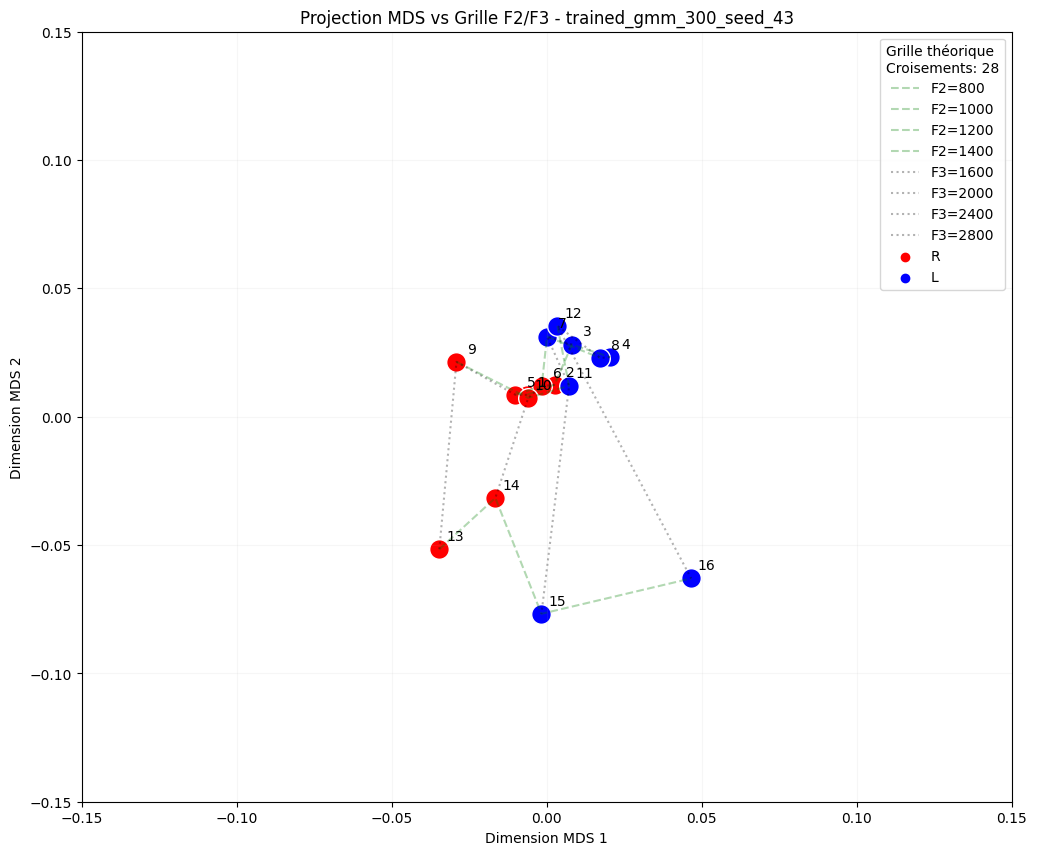

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/julienf/.pyenv/versions/3.11.11/envs/ml/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


trained_gmm_300_seed_75
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 721.91it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 534.99it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 612.40it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 510.75it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 781.21it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 807.68it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.47it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 692.93it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 710.18it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 471.75it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 593.17it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 427.51it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 597.39it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 488.56it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 477.55it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 168.34it/s]


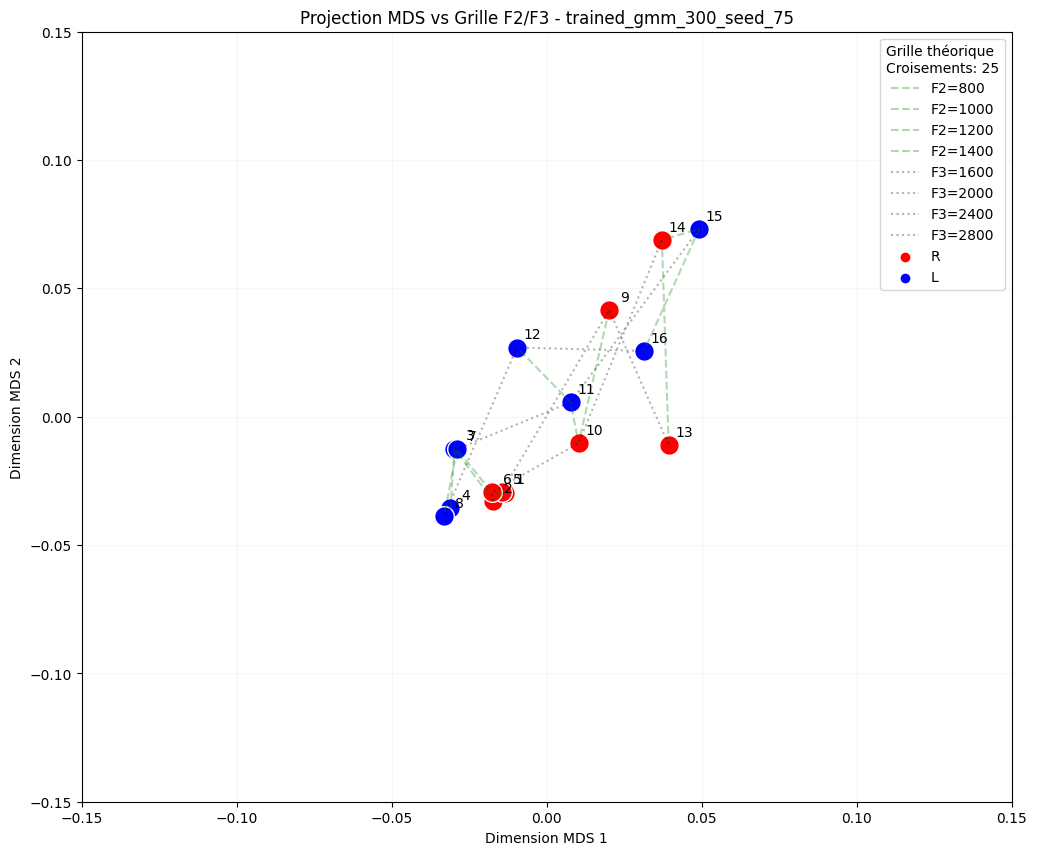

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/julienf/.pyenv/versions/3.11.11/envs/ml/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


trained_gmm_300_seed_34
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 712.71it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 343.96it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 451.83it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 457.24it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 397.45it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 390.64it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 687.70it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 432.76it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 781.21it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 607.87it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 643.40it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 536.22it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 212.98it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 516.73it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 781.79it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 494.84it/s]
error  trained_gmm_300_seed_34
trained_gmm_300_seed_12


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/julienf/.pyenv/versions/3.11.11/envs/ml/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 791.68it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 470.79it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 603.76it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 496.25it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.76it/s] 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 486.41it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 527.78it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 414.09it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 350.72it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 577.09it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 453.10it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 178.57it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 702.68it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 579.40it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 631.29it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 478.69it/s]


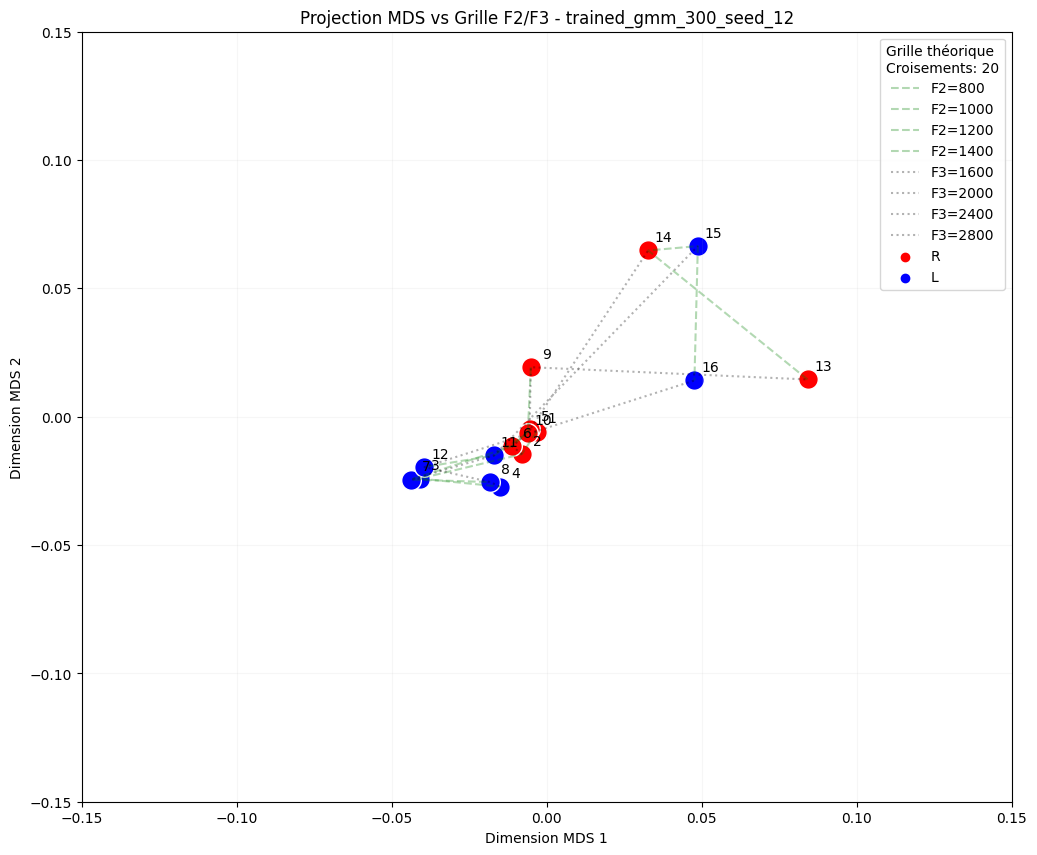

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/julienf/.pyenv/versions/3.11.11/envs/ml/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


trained_gmm_300_seed_734
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 581.01it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 406.03it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 312.01it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 620.73it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 629.96it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 480.34it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 570.03it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 482.60it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 657.93it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 389.23it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 559.32it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 489.30it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 553.70it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 469.06it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 582.06it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.60it/s]


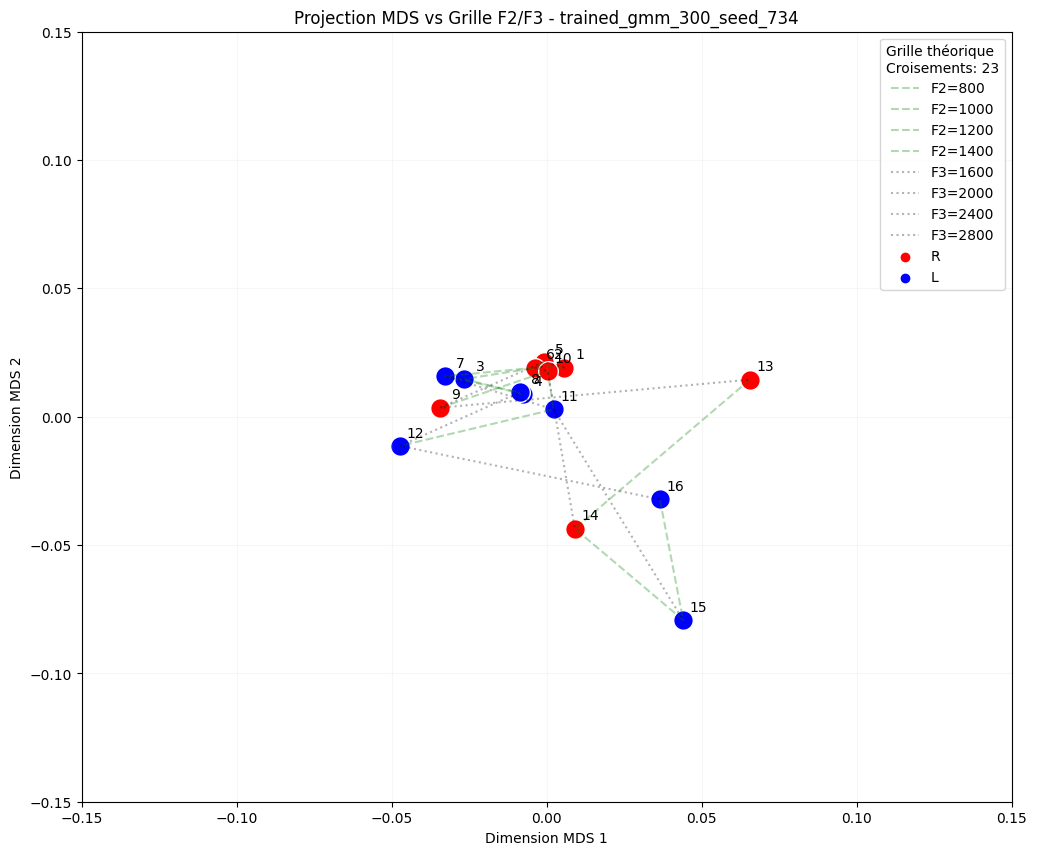

In [16]:
path_to_models="./data/trained_models/30mn"

# Fonction utilitaire de détection d'intersection
def lines_intersect(line1, line2):
    """Détecte si deux lignes (série de points) se croisent"""
    from itertools import combinations
    for (p1, p2), (p3, p4) in combinations(zip(line1, line1[1:]), 2):
        if segment_intersect(p1, p2, p3, p4):
            return True
    return False

def segment_intersect(a, b, c, d):
    """Détecte l'intersection entre deux segments [a,b] et [c,d]"""
    def ccw(A, B, C):
        return (B[0]-A[0])*(C[1]-A[1]) > (B[1]-A[1])*(C[0]-A[0])
    
    return ccw(a,c,d) != ccw(b,c,d) and ccw(a,b,c) != ccw(a,b,d)

f3 = [1600,
2000,
2400,
2800,
1600,
2000,
2400,
2800,
1600,
2000,
2400,
2800,
1600,
2000,
2400,
2800] 

f2 = [800,
800,
800,
800,
1000,
1000,
1000,
1000,
1200,
1200,
1200,
1200,
1400,
1400,
1400,
1400]

models=os.listdir(path_to_models)
models=[model for model in models if "seed" in model]
print(models)
for model in models:
    try:
        print(model)
        model_path=os.path.join(path_to_models,model)
        gmm = bayes.GaussianMixture.load(model_path)
        stimulus_embeddings = []
        for mfcc in stimulus_mfccs:  # Utilisez vos MFCC pré-calculés
            with torch.no_grad():
                mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32)
                responsibilities = gmm.predict_proba(mfcc_tensor)
                avg_embedding = responsibilities.mean(dim=0).numpy()
                stimulus_embeddings.append(avg_embedding)

        # --- 3. Calcul de la matrice de distance ---
        distance_matrix = squareform(pdist(stimulus_embeddings, metric='cosine'))

        # --- 4. Réduction de dimension avec MDS ---
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        mds_coords = mds.fit_transform(distance_matrix)

        # --- 5. Visualisation ---
        plt.figure(figsize=(12, 10))
        colors = ['red' if label == 'r' else 'blue' for label in stimulus_labels]

        # Définir la grille théorique basée sur F2/F3
        f2_groups = {800: [], 1000: [], 1200: [], 1400: []}
        f3_groups = {1600: [], 2000: [], 2400: [], 2800: []}

        for i, (x, y) in enumerate(mds_coords):
            # Stocker les coordonnées par groupe F2/F3
            f2_groups[f2[i]].append((x, y))
            f3_groups[f3[i]].append((x, y))
            
            # Plot des points
            plt.scatter(x, y, c=colors[i], s=200, edgecolor='w', linewidth=1)
            plt.text(x+0.005, y+0.005, str(i+1), fontsize=10, ha='center', va='center')

        # Tracer les lignes théoriques
        for f2_val, coords in f2_groups.items():
            if len(coords) == 4:  # Lignes F3 (même F2)
                x_vals = [c[0] for c in coords]
                y_vals = [c[1] for c in coords]
                plt.plot(x_vals, y_vals, '--', color='green', alpha=0.3, label=f'F2={f2_val}')

        for f3_val, coords in f3_groups.items():
            if len(coords) == 4:  # Lignes F2 (même F3)
                x_vals = [c[0] for c in coords]
                y_vals = [c[1] for c in coords]
                plt.plot(x_vals, y_vals, ':', color='black', alpha=0.3, label=f'F3={f3_val}')

        # Analyse des croisements
        crossing_count = 0
        all_lines = list(f2_groups.values()) + list(f3_groups.values())

        for i in range(len(all_lines)):
            for j in range(i+1, len(all_lines)):
                if lines_intersect(all_lines[i], all_lines[j]):
                    crossing_count += 1

        # Légende et annotations
        plt.scatter([], [], c='red', label='R')
        plt.scatter([], [], c='blue', label='L')
        plt.legend(title=f"Grille théorique\nCroisements: {crossing_count}", loc='upper right')

        plt.title(f"Projection MDS vs Grille F2/F3 - {model}")
        plt.xlabel("Dimension MDS 1")
        plt.ylabel("Dimension MDS 2")

        plt.xlim(-0.15,0.15)
        plt.ylim(-0.15,0.15)
        plt.grid(alpha=0.1)

        plt.savefig(f"./plots/{model}.png")

        plt.show()
    except:
        print("error ", model)
        pass

    

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/julienf/.pyenv/versions/3.11.11/envs/ml/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 448.83it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 560.21it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 639.38it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 459.35it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.13it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 509.14it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 492.35it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 644.68it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 586.21it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 559.61it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 572.05it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 198.96it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 643.89it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 650.18it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 531.66it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 635.02it/s]


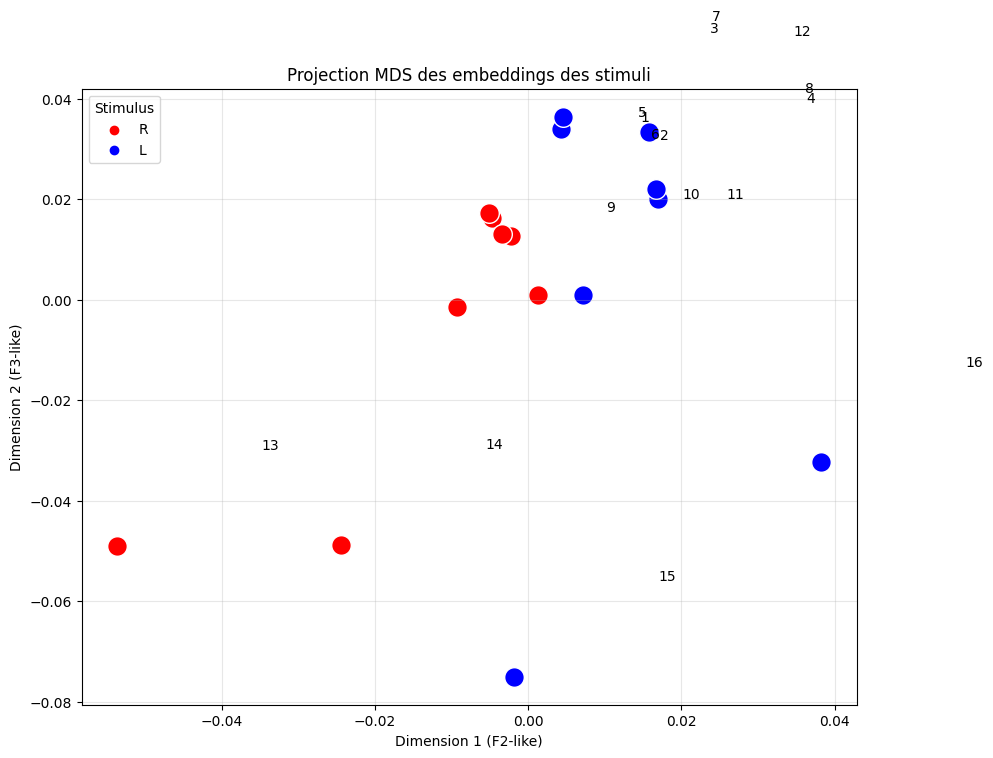

In [22]:


# --- 1. Charger le modèle entraîné ---
model_path = "./data/trained_models/halfhour_trained_gmm"  # <-- À modifier
gmm = bayes.GaussianMixture.load(model_path)


# --- 2. Calcul des embeddings des stimuli ---
stimulus_embeddings = []
for mfcc in stimulus_mfccs:  # Utilisez vos MFCC pré-calculés
    with torch.no_grad():
        mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32)
        responsibilities = gmm.predict_proba(mfcc_tensor)
        avg_embedding = responsibilities.mean(dim=0).numpy()
        stimulus_embeddings.append(avg_embedding)

# --- 3. Calcul de la matrice de distance ---
distance_matrix = squareform(pdist(stimulus_embeddings, metric='cosine'))

# --- 4. Réduction de dimension avec MDS ---
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_coords = mds.fit_transform(distance_matrix)

# --- 5. Visualisation ---
plt.figure(figsize=(10, 8))
colors = ['red' if label == 'r' else 'blue' for label in stimulus_labels]

# Plot chaque stimulus avec son numéro
for i, (x, y) in enumerate(mds_coords):
    plt.scatter(x, y, c=colors[i], s=200, edgecolor='w', linewidth=1)
    plt.text(x+0.02, y+0.02, str(i+1), fontsize=10, ha='center', va='center')

# Légende
plt.scatter([], [], c='red', label='R')
plt.scatter([], [], c='blue', label='L')
plt.legend(title="Stimulus")

plt.title("Projection MDS des embeddings des stimuli")
plt.xlabel("Dimension 1 (F2-like)")
plt.ylabel("Dimension 2 (F3-like)")
plt.grid(alpha=0.3)
plt.show()

# --- 6. Sauvegarde des résultats ---
np.save("mds_coords.npy", mds_coords)
np.save("distance_matrix.npy", distance_matrix)

In [23]:
# Si vous avez les formants réels des stimuli
from scipy.stats import pearsonr

# Corrélation Dimension 1 ↔ F2 moyen
f2 = [800,
800,
800,
800,
1000,
1000,
1000,
1000,
1200,
1200,
1200,
1200,
1400,
1400,
1400,
1400] # Valeurs F2 pour chaque stimulus
r, p = pearsonr(mds_coords[:,0], f2)
print(f"Corrélation Dim1-F2 : r={r:.2f}, p={p:.3f}")

# Corrélation Dimension 2 ↔ F3 moyen
f3 = [1600,
2000,
2400,
2800,
1600,
2000,
2400,
2800,
1600,
2000,
2400,
2800,
1600,
2000,
2400,
2800] # Valeurs F3 pour chaque stimulus
r, p = pearsonr(mds_coords[:,1], f3)
print(f"Corrélation Dim2-F3 : r={r:.2f}, p={p:.3f}")

Corrélation Dim1-F2 : r=-0.24, p=0.372
Corrélation Dim2-F3 : r=0.17, p=0.526


In [ ]:
# Fonction utilitaire de détection d'intersection
def lines_intersect(line1, line2):
    """Détecte si deux lignes (série de points) se croisent"""
    from itertools import combinations
    for (p1, p2), (p3, p4) in combinations(zip(line1, line1[1:]), 2):
        if segment_intersect(p1, p2, p3, p4):
            return True
    return False

def segment_intersect(a, b, c, d):
    """Détecte l'intersection entre deux segments [a,b] et [c,d]"""
    def ccw(A, B, C):
        return (B[0]-A[0])*(C[1]-A[1]) > (B[1]-A[1])*(C[0]-A[0])
    
    return ccw(a,c,d) != ccw(b,c,d) and ccw(a,b,c) != ccw(a,b,d)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/julienf/.pyenv/versions/3.11.11/envs/ml/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 498.49it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 378.92it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 526.86it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 434.24it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 484.27it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 331.88it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 522.46it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 500.51it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.55it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 391.04it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 563.75it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 461.01it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 496.25it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 555.54it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 426.81it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 562.09it/s]


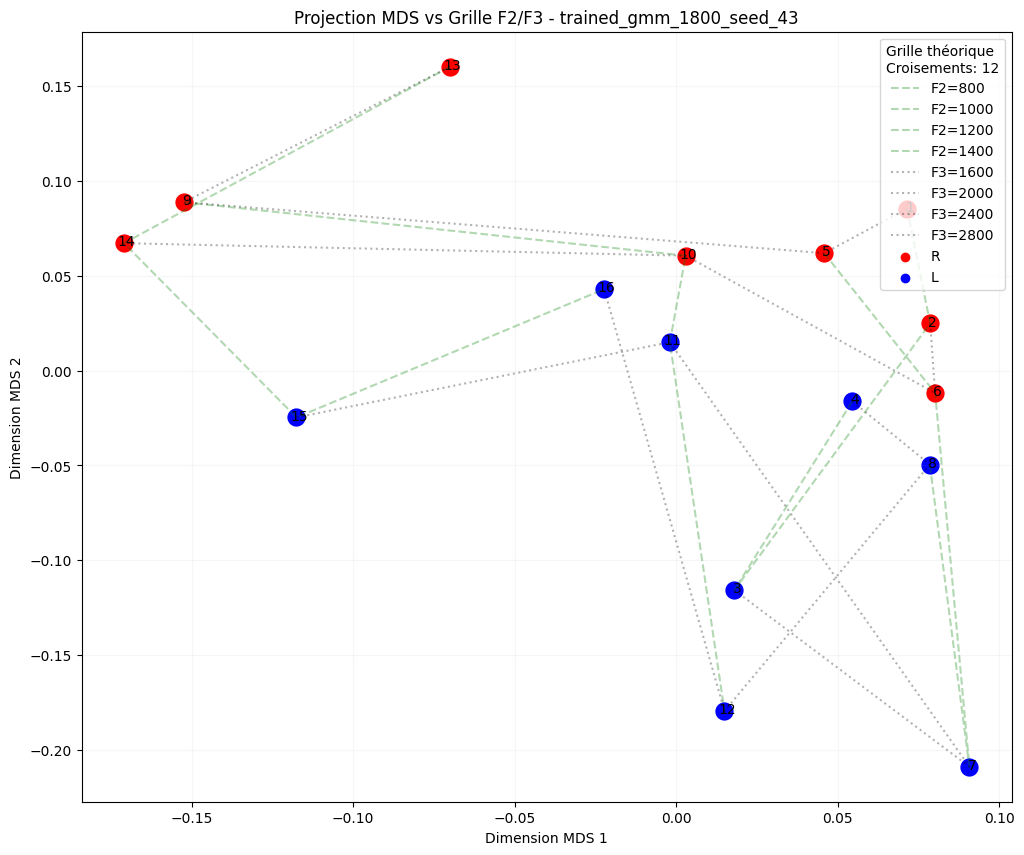

In [33]:


# --- 1. Charger le modèle entraîné ---
model_path = "./data/trained_models/10h_trained_gmm"  # <-- À modifier
gmm = bayes.GaussianMixture.load(model_path)


# --- 2. Calcul des embeddings des stimuli ---
stimulus_embeddings = []
for mfcc in stimulus_mfccs:  # Utilisez vos MFCC pré-calculés
    with torch.no_grad():
        mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32)
        responsibilities = gmm.predict_proba(mfcc_tensor)
        avg_embedding = responsibilities.mean(dim=0).numpy()
        stimulus_embeddings.append(avg_embedding)

# --- 3. Calcul de la matrice de distance ---
distance_matrix = squareform(pdist(stimulus_embeddings, metric='cosine'))

# --- 4. Réduction de dimension avec MDS ---
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_coords = mds.fit_transform(distance_matrix)




# --- 5. Visualisation AVEC GRILLE THÉORIQUE ---
plt.figure(figsize=(12, 10))
colors = ['red' if label == 'r' else 'blue' for label in stimulus_labels]

# Définir la grille théorique basée sur F2/F3
f2_groups = {800: [], 1000: [], 1200: [], 1400: []}
f3_groups = {1600: [], 2000: [], 2400: [], 2800: []}

for i, (x, y) in enumerate(mds_coords):
    # Stocker les coordonnées par groupe F2/F3
    f2_groups[f2[i]].append((x, y))
    f3_groups[f3[i]].append((x, y))
    
    # Plot des points
    plt.scatter(x, y, c=colors[i], s=200, edgecolor='w', linewidth=1)
    plt.text(x+0.0008, y+0.0008, str(i+1), fontsize=10, ha='center', va='center')

# Tracer les lignes théoriques
for f2_val, coords in f2_groups.items():
    if len(coords) == 4:  # Lignes F3 (même F2)
        x_vals = [c[0] for c in coords]
        y_vals = [c[1] for c in coords]
        plt.plot(x_vals, y_vals, '--', color='green', alpha=0.3, label=f'F2={f2_val}')

for f3_val, coords in f3_groups.items():
    if len(coords) == 4:  # Lignes F2 (même F3)
        x_vals = [c[0] for c in coords]
        y_vals = [c[1] for c in coords]
        plt.plot(x_vals, y_vals, ':', color='black', alpha=0.3, label=f'F3={f3_val}')

# Analyse des croisements
crossing_count = 0
all_lines = list(f2_groups.values()) + list(f3_groups.values())

for i in range(len(all_lines)):
    for j in range(i+1, len(all_lines)):
        if lines_intersect(all_lines[i], all_lines[j]):
            crossing_count += 1

# Légende et annotations
plt.scatter([], [], c='red', label='R')
plt.scatter([], [], c='blue', label='L')
plt.legend(title=f"Grille théorique\nCroisements: {crossing_count}", loc='upper right')

plt.title(f"Projection MDS vs Grille F2/F3 - {model}")
plt.xlabel("Dimension MDS 1")
plt.ylabel("Dimension MDS 2")
plt.grid(alpha=0.1)

plt.show()



In [ ]:
#a implementer : plusieurs seeds, plusieurs durées, comparaison des durées

import numpy as np
from sklearn.manifold import MDS
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration globale
N_COMPONENTS = 128  
N_MDS_DIMENSIONS = 2
TRAINING_DURATIONS = ['1h', '10h', '100h']
N_SEEDS = 1

# Fonction pour charger les modèles entraînés
def load_models(duration, n_seeds):
    models = []
    for seed in range(n_seeds):
        model_path = f"./models/gmm_{duration}_seed{seed}.pt"
        models.append(torch.load(model_path))
    return models

# Calcul des embeddings moyens sur plusieurs runs
def compute_average_embeddings(models, stimulus_mfccs):
    all_embeddings = []
    for model in models:
        embeddings = []
        for mfcc in stimulus_mfccs:
            mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32)
            responsibilities = model.predict_proba(mfcc_tensor)
            avg_resp = responsibilities.mean(dim=0).detach().cpu().numpy()
            embeddings.append(avg_resp)
        all_embeddings.append(np.array(embeddings))
    return np.mean(all_embeddings, axis=0)

# Analyse MDS pour une durée d'entraînement
def analyze_duration(duration, stimulus_mfccs, stimulus_labels):
    # Charger les modèles
    models = load_models(duration, N_SEEDS)
    
    # Calculer les embeddings moyens
    avg_embeddings = compute_average_embeddings(models, stimulus_mfccs)
    
    # Calcul de la matrice de distance moyenne
    distance_matrix = cdist(avg_embeddings, avg_embeddings, metric='cosine')
    
    # Réduction de dimension avec MDS
    mds = MDS(n_components=N_MDS_DIMENSIONS, dissimilarity='precomputed', random_state=42)
    mds_coords = mds.fit_transform(distance_matrix)
    
    # Visualisation
    plt.figure(figsize=(10, 8))
    colors = ['red' if label == 'R' else 'blue' for label in stimulus_labels]
    
    for i, (x, y) in enumerate(mds_coords):
        plt.scatter(x, y, c=colors[i], s=100)
        plt.text(x+0.02, y+0.02, str(i+1), fontsize=9)
    
    plt.title(f"MDS - {duration} d'entraînement")
    plt.xlabel("Dimension 1 (F2-like)")
    plt.ylabel("Dimension 2 (F3-like)")
    
    # Sauvegarde des coordonnées
    np.save(f"mds_{duration}.npy", mds_coords)
    plt.savefig(f"mds_{duration}.png")
    plt.close()

# Analyse comparative sur toutes les durées
def full_analysis(stimulus_mfccs, stimulus_labels):
    fig, axes = plt.subplots(1, len(TRAINING_DURATIONS), figsize=(20, 6))
    
    for idx, duration in enumerate(TRAINING_DURATIONS):
        models = load_models(duration, N_SEEDS)
        avg_embeddings = compute_average_embeddings(models, stimulus_mfccs)
        distance_matrix = cdist(avg_embeddings, avg_embeddings, metric='cosine')
        mds = MDS(n_components=N_MDS_DIMENSIONS, dissimilarity='precomputed', random_state=42)
        mds_coords = mds.fit_transform(distance_matrix)
        
        colors = ['red' if label == 'R' else 'blue' for label in stimulus_labels]
        axes[idx].scatter(mds_coords[:,0], mds_coords[:,1], c=colors, s=100)
        axes[idx].set_title(duration)
        axes[idx].set_xlabel("Dimension 1")
        axes[idx].set_ylabel("Dimension 2")
    
    plt.tight_layout()
    plt.savefig("mds_comparison.png")
    plt.close()

# Exécution principale
if __name__ == "__main__":
    # Charger les MFCC des stimuli (déjà calculés)
    stimulus_mfccs = [...]  # Remplacer par vos données
    
    # Vérifier les labels
    stimulus_labels = [...]  # Liste de 16 labels R/L
    
    # Analyse par durée
    for duration in TRAINING_DURATIONS:
        analyze_duration(duration, stimulus_mfccs, stimulus_labels)
    
    # Analyse comparative
    full_analysis(stimulus_mfccs, stimulus_labels)

    # Analyse statistique des dimensions
    for duration in TRAINING_DURATIONS:
        coords = np.load(f"mds_{duration}.npy")
        print(f"\nAnalyse pour {duration}:")
        print(f"Variance expliquée - Dim1: {np.var(coords[:,0]):.2f}, Dim2: {np.var(coords[:,1]):.2f}")
        print(f"Ratio F2/F3: {np.var(coords[:,0])/np.var(coords[:,1]):.2f}")